# FirstTokenRepeatsOnce Dataset Max Grad Analysis

In [1]:
from datetime import datetime
import json
import numpy as np
import pandas as pd
import os
import seaborn as sns

from matplotlib import font_manager as fm, pyplot as plt
import matplotlib as mpl
import wandb

### Preamble
Paths, plot formatting, colors, and WandB stuff

In [2]:
# Paths
DATA_DIR = "../data/FirstTokenRepeatedOnce/FirstTokenRepeatedOnce-num_points10000-vs20-seqlen10/1.0-0/"
MODEL_ID = "Bert-hs16-numheads2-bs32-lr0.001-n42-dropoutprob0.2"
# RESULTS_DIR = os.path.join(DATA_DIR, "results/max_grad", MODEL_ID)
RESULTS_DIR = os.path.join(DATA_DIR, "results/max_grad/oplus", MODEL_ID)
AGG_MAX_GRAD_RESULTS_PATH = os.path.join(RESULTS_DIR, "agg_max_grad_results.csv")
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

In [3]:
# Plot formatting
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

try:
    # Set the font properties globally
    font_path = './fonts/cmunbx.otf'
    font_prop = fm.FontProperties(fname=font_path, size=12)
    plt.rc('font', family=font_prop.get_name())
except:
    print("Unable to set font to Computer Modern (cmunbx.otf)")

In [4]:
# Set color theme for keys, values, queries, and skip
palette = sns.color_palette("colorblind", 5)
palette = palette[:3] + palette[-1:]
print("Colors:", [mpl.colors.to_hex(c) for c in palette])
sns.set_palette(palette)

Colors: ['#0173b2', '#de8f05', '#029e73', '#cc78bc']


In [5]:
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(
    os.getcwd(), "synthetic_bert_max_grad.ipynb"
)
entity, PROJECT_NAME = "kdu", "bauer-kvq-synthetic"  # set to your entity and project
config = {
    "MODEL_ID": MODEL_ID,
    "AGG_MAX_GRAD_RESULTS_PATH": AGG_MAX_GRAD_RESULTS_PATH,
    "palette": palette,
}
run = wandb.init(
    project=PROJECT_NAME,
    name=f"analyze_firsttokenrepeatsonce_max_grad_{datetime.now().isoformat(sep='_', timespec='seconds')}",
    tags=["analysis", "firsttokenrepeatsonce"],
    config=config,
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: No data
wandb: ERROR Failed to sample metric: Not Supported


{'MODEL_ID': 'Bert-hs16-numheads2-bs32-lr0.001-n42-dropoutprob0.2', 'AGG_MAX_GRAD_RESULTS_PATH': '../data/FirstTokenRepeatedOnce/FirstTokenRepeatedOnce-num_points10000-vs20-seqlen10/1.0-0/results/max_grad/oplus/Bert-hs16-numheads2-bs32-lr0.001-n42-dropoutprob0.2/agg_max_grad_results.csv', 'palette': [[0.00392156862745098, 0.45098039215686275, 0.6980392156862745], [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], [0.8, 0.47058823529411764, 0.7372549019607844]]}


## Load Data

In [6]:
df = pd.read_csv(AGG_MAX_GRAD_RESULTS_PATH)
df['num_tokens'] = (df.groupby('sentence_index')['sentence_index'].transform('count') / len(df["layer_num"].unique()) / len(df["path_name"].unique())).astype(int)
df["path_name"].replace(
    to_replace={
        "matmul (bertselfattention key)": "Self-Attention Key",
        "matmul (bertselfattention mixed_query_layer)": "Self-Attention Query",
        "matmul (bertselfattention value)": "Self-Attention Value",
        "skip layer": "Skip Connection",
    },
    inplace=True
)
df = df.sort_values(["sentence_index", "token_index", "layer_num", "path_name"]).reset_index().drop(columns=["index"])
df


,sentence_index,is_correct,correct_pred_logit,incorrect_pred_logit,token,token_index,layer_num,path_name,path grad,sentence,num_tokens
0,0,True,5.758648,-5.674770,4,0,0,Self-Attention Key,0.000000,"[4, 10, 1, 9, 16, 2, 9, 11, 8, 6]",10
1,0,True,5.758648,-5.674770,4,0,0,Self-Attention Query,0.443612,"[4, 10, 1, 9, 16, 2, 9, 11, 8, 6]",10
2,0,True,5.758648,-5.674770,4,0,0,Self-Attention Value,0.000000,"[4, 10, 1, 9, 16, 2, 9, 11, 8, 6]",10
3,0,True,5.758648,-5.674770,4,0,0,Skip Connection,0.000000,"[4, 10, 1, 9, 16, 2, 9, 11, 8, 6]",10
4,0,True,5.758648,-5.674770,10,1,0,Self-Attention Key,0.000107,"[4, 10, 1, 9, 16, 2, 9, 11, 8, 6]",10
...,...,...,...,...,...,...,...,...,...,...,...
39995,999,True,5.935697,-5.849848,4,8,0,Skip Connection,0.000000,"[11, 12, 2, 8, 19, 10, 15, 3, 4, 7]",10
39996,999,True,5.935697,-5.849848,7,9,0,Self-Attention Key,0.000000,"[11, 12, 2, 8, 19, 10, 15, 3, 4, 7]",10
39997,999,True,5.935697,-5.849848,7,9,0,Self-Attention Query,0.000000,"[11, 12, 2, 8, 19, 10, 15, 3, 4, 7]",10
39998,999,True,5.935697,-5.849848,7,9,0,Self-Attention Value,0.001119,"[11, 12, 2, 8, 19, 10, 15, 3, 4, 7]",10


In [7]:
# Correctness sanity check - we expect this to be high performing
df.groupby("sentence_index")["is_correct"].agg("mean").value_counts()

1.0    1000
Name: is_correct, dtype: int64

## Prepare Dataframe

In [8]:
df_analysis = df.groupby(['path_name', 'layer_num']).agg({"path grad": "mean"})
table = wandb.Table(dataframe=df_analysis)
wandb.log({"path_grads_summary_all_words": table})
df_analysis

,,path grad
path_name,layer_num,
Self-Attention Key,0,0.030058
Self-Attention Query,0,0.017406
Self-Attention Value,0,0.000952
Skip Connection,0,0.009444


### Gradient split between K/V/Q and Skip layer for different layers 
(avg across all tokens)

Text(0.5, 1.0, "Gradient flow through keys, values, and queries per each token index (avg'd across all sentences)")

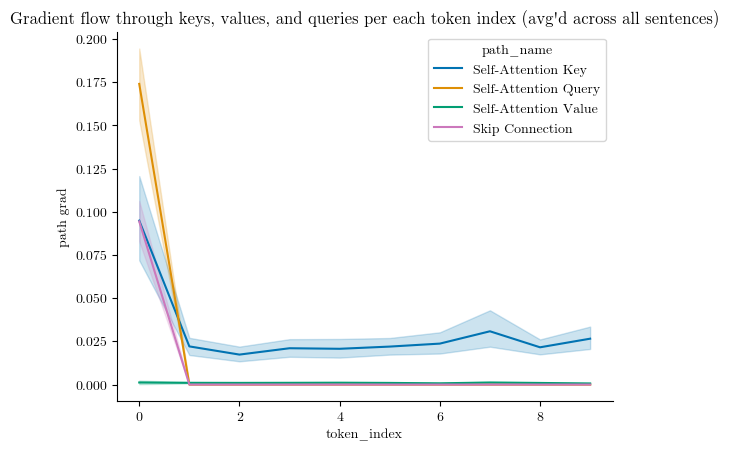

In [9]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="token_index", y="path grad", hue="path_name", ax=ax)
ax.set_title("Gradient flow through keys, values, and queries per each token index (avg'd across all sentences)", wrap=True)

In [10]:
def get_token_type(row, df):
    def is_repeat_token(row):
        sentence_df = df[(df["sentence_index"] == row["sentence_index"])]
        first_token_in_sentence = sentence_df[sentence_df["token_index"] == 0].iloc[0]["token"]
        return row["token"] == first_token_in_sentence
    if row["token_index"] == 0:
        return "FirstToken"
    elif is_repeat_token(row):
        return "RepeatToken"
    else:
        return "OtherToken"
        
df["token_type"] = df.apply(lambda x: get_token_type(x, df), axis=1)

In [11]:
# Quick sanity check that token_type is computed correctly for repeat tokens
sentences = df["sentence"].apply(json.loads).apply(tuple).unique()
num_sents_with_repeat = sum([s[0] in s[1:] for s in sentences])
num_rows_with_repeat_token_type = (df["token_type"] == "RepeatToken").sum()
print("Num sentences with a repeat token:", num_sents_with_repeat)
assert num_sents_with_repeat * 4 == num_rows_with_repeat_token_type # There are 4 path types so each token has 4 rows.

Num sentences with a repeat token: 476


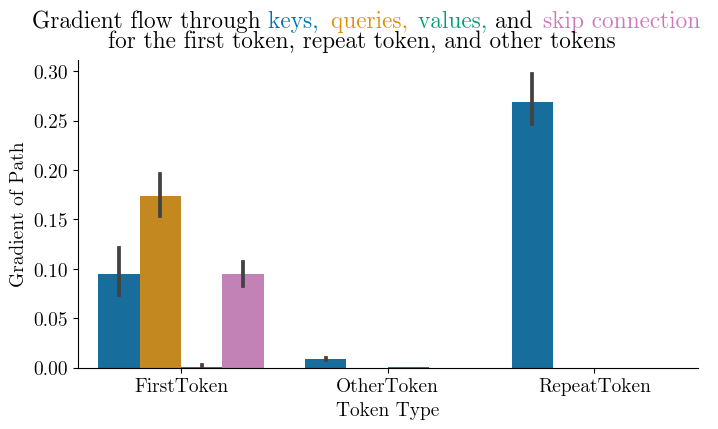

In [16]:
# Gradient Split for First Token, Repeated Token, and Other Tokens.
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=df, x="token_type", y="path grad", hue="path_name", ax=ax)

ax.legend_.remove()
ax.set_xlabel("Token Type")
ax.set_ylabel("Gradient of Path")
linecolors = palette
offset = 0.215
fig.text(0. + offset, 0.95, "Gradient flow through ", ha="center", va="bottom", size="large", color="black")
fig.text(0.184 + offset, 0.95, "keys, ", ha="center", va="bottom", size="large", color=linecolors[0])
fig.text(0.28 + offset, 0.95, "queries, ", ha="center", va="bottom", size="large", color=linecolors[1])
fig.text(0.384 + offset, 0.95, "values, ", ha="center", va="bottom", size="large", color=linecolors[2])
fig.text(0.46 + offset, 0.95, "and ", ha="center", va="bottom", size="large", color="black")
fig.text(0.595 + offset, 0.95, "skip connection ", ha="center", va="bottom", size="large", color=linecolors[3])
fig.text(0.27 + offset, 0.9, "for the first token, repeat token, and other tokens ", ha="center", va="bottom", size="large", color="black")

# offset = 0.46
# offset2 = 0.02
# offset3 = 0.215
# fig.text(0. + offset, 1.1, "Gradient flow through ", ha="center", va="bottom", size="large", color="black")
# fig.text(0.184 + offset2, 1.03, "keys, ", ha="center", va="bottom", size="large", color=linecolors[0])
# fig.text(0.3 + offset2, 1.03, "queries, ", ha="center", va="bottom", size="large", color=linecolors[1])
# fig.text(0.42 + offset2, 1.03, "values, ", ha="center", va="bottom", size="large", color=linecolors[2])
# fig.text(0.51 + offset2, 1.03, "and ", ha="center", va="bottom", size="large", color="black")
# fig.text(0.67 + offset2, 1.03, "skip connection ", ha="center", va="bottom", size="large", color=linecolors[3])
# fig.text(0.27 + offset3, 0.96, "for the first token, repeat token, and other tokens ", ha="center", va="bottom", size="large", color="black")

fig_name = "max_grad_kvqskip_tokens_synthetic"
save_path = os.path.join(PLOTS_DIR, f"{fig_name}.png")
save_path_pdf = os.path.join(PLOTS_DIR, f"{fig_name}.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({fig_name: wandb.Image(save_path)})

In [13]:
wandb.finish()